# Video Engagement Score Analysis

This notebook aggregates and analyzes YouTube video data to compute video engagement scores. It loads pre-processed comment and video datasets, calculates average KPIs per video, filters and cleans the data, and computes both raw and weighted engagement metrics. The notebook visualizes distributions, explores relationships between engagement and KPIs, and prepares a final output for reporting or downstream analysis.

**Key steps include:**
- Loading and aligning comment and video datasets
- Calculating average KPI and comment count per video
- Filtering and cleaning video metadata
- Computing and scaling engagement scores
- Visualizing distributions and relationships
- Preparing and exporting the final video-level dataset

## Import Required Libraries and Set Display Options
This cell imports all necessary libraries for data manipulation and visualization, enables progress bars, configures pandas display options, and disables scientific notation and warnings.

In [ ]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
# Enable tqdm for pandas apply
tqdm.pandas()

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Show full text without truncation
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", 500) 

# Disable scientific notation
pd.set_option('display.float_format', '{:.6f}'.format)

## Load Comments Dataset
This cell loads the comments dataset, which contains comment-level KPIs and metadata, for further aggregation and analysis at the video level.

In [ ]:
comments = pd.read_csv("dataset/final_dataset_with_kpi.csv")

## Display Comments Dataset Shape
This cell displays the shape of the loaded comments dataset to confirm successful loading and check the number of records.

In [ ]:
comments.shape

(2014093, 23)

## Calculate Average KPI per Video
This cell groups the comments by videoId and calculates the average KPI and comment count for each video, creating a summary DataFrame for video-level analysis.

In [ ]:
# calculate the average KPI for each video 
video_avg_kpi = (
    comments.groupby("videoId")
    .agg(
        KPI=("KPI", "mean"),
        comment_count=("commentId", "count")
    )
    .reset_index()
)

video_avg_kpi.head()


,videoId,KPI,comment_count
0,2,0.214784,1
1,6,0.426398,4
2,8,0.272670,6
3,11,0.322106,247
4,22,0.389371,1


## Get List of Valid Video IDs
This cell extracts the unique video IDs present in the comments dataset and displays their count, ensuring only relevant videos are included in further analysis.

In [ ]:
valid_videoId = comments['videoId'].unique().tolist()
len(valid_videoId)

25590

## Load and Filter Video Metadata
This cell loads the video metadata, then filters it to include only videos present in the comments dataset, ensuring alignment between datasets.

In [ ]:
video = pd.read_csv("dataset/videos_cleaned_translated.csv")
video.shape

(91113, 21)

## Keep Only Videos with Comments
This cell filters the video metadata to retain only those videos that have corresponding comments, ensuring consistency for further analysis.

In [ ]:
# only take those that are present in the comments dataset 
video = video[video['videoId'].isin(valid_videoId)]
video.shape

(25590, 21)

## Merge Video Metadata with KPI Data
This cell merges the filtered video metadata with the average KPI and comment count for each video, creating a comprehensive video-level dataset.

In [ ]:
video = video.merge(video_avg_kpi, on='videoId', how = 'inner')
video.shape

(24138, 23)

## Fill Missing Like Counts and Check for Nulls
This cell fills missing like counts with zero and checks for any remaining null values in the like, view, and comment count columns.

In [ ]:
video['likeCount'] = video['likeCount'].fillna(0)
video[['likeCount', 'viewCount', 'commentCount']].isna().sum()

likeCount       0
viewCount       0
commentCount    0
dtype: int64

## Describe Engagement Columns
This cell provides descriptive statistics for the like, view, and comment count columns, summarizing their distributions.

In [ ]:
video[['likeCount', 'viewCount', 'commentCount']].describe().T

,count,mean,std,min,25%,50%,75%,max
likeCount,24138.000000,24579.571671,152763.850987,0.000000,36.000000,191.500000,1726.750000,7162433.000000
viewCount,24138.000000,825455.942912,5947209.363465,1.000000,1288.000000,7072.000000,56872.500000,405748145.000000
commentCount,24138.000000,226.940094,1768.642858,0.000000,3.000000,8.000000,35.000000,78195.000000


## Calculate Engagement Score
This cell calculates the engagement score for each video as the sum of likes and comments divided by views, handling cases where view count is zero.

In [ ]:
video['engagement_score'] = video.progress_apply(
    lambda row: (row['likeCount'] + row['commentCount']) / row['viewCount'] if row['viewCount'] > 0 else 0,
    axis=1
)

100%|██████████| 24138/24138 [00:00<00:00, 64391.34it/s]


## Describe Engagement Score
This cell provides descriptive statistics for the calculated engagement score, summarizing its distribution across all videos.

In [ ]:
video['engagement_score'].describe().T

count   24138.000000
mean        0.050033
std         0.068518
min         0.000000
25%         0.020762
50%         0.034029
75%         0.054333
max         1.640299
Name: engagement_score, dtype: float64

## Clip Engagement Score to [0, 1]
This cell clips the engagement score to ensure all values are between 0 and 1, then summarizes the clipped values.

In [ ]:
video['engagement_score'] = np.clip(video['engagement_score'], 0, 1)
video['engagement_score'].describe().T

count   24138.000000
mean        0.049925
std         0.066617
min         0.000000
25%         0.020762
50%         0.034029
75%         0.054333
max         1.000000
Name: engagement_score, dtype: float64

## Calculate Weighted Engagement Score
This cell calculates a weighted engagement score for each video, combining the engagement score and the log of likes/comments, and summarizes the result.

In [ ]:
alpha = 0.8
beta = 0.2

video['weighted_engagement_score'] = video.progress_apply(
    lambda row: alpha*row['engagement_score'] + beta*np.log1p(row['likeCount'] + row['commentCount']),
    axis=1
)

video['weighted_engagement_score'].describe().T

100%|██████████| 24138/24138 [00:00<00:00, 66234.34it/s]


count   24138.000000
mean        1.215537
std         0.546150
min         0.000000
25%         0.796338
50%         1.103678
75%         1.534759
max         3.178672
Name: weighted_engagement_score, dtype: float64

## Plot Weighted Engagement Score Distribution
This cell plots a histogram of the weighted engagement score to visualize its distribution across all videos.

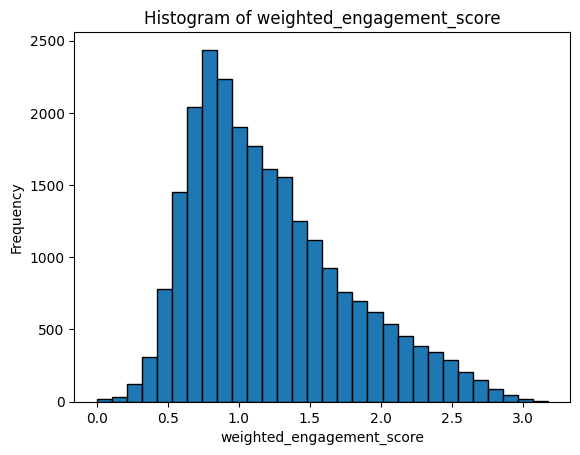

In [ ]:
video['weighted_engagement_score'].plot(kind='hist', bins=30, edgecolor='black')
plt.title('Histogram of weighted_engagement_score')
plt.xlabel('weighted_engagement_score')
plt.ylabel('Frequency')
plt.show()

## Scale Weighted Engagement Score
This cell scales the weighted engagement score to the [0, 1] range using MinMaxScaler for comparability and further analysis.

In [ ]:
# Initialize scaler
scaler = MinMaxScaler()

# Fit and transform the KPI column
video['weighted_engagement_score_scaled'] = scaler.fit_transform(video[['weighted_engagement_score']])


## Plot Scaled Weighted Engagement Score
This cell plots a histogram of the scaled weighted engagement score to visualize its normalized distribution.

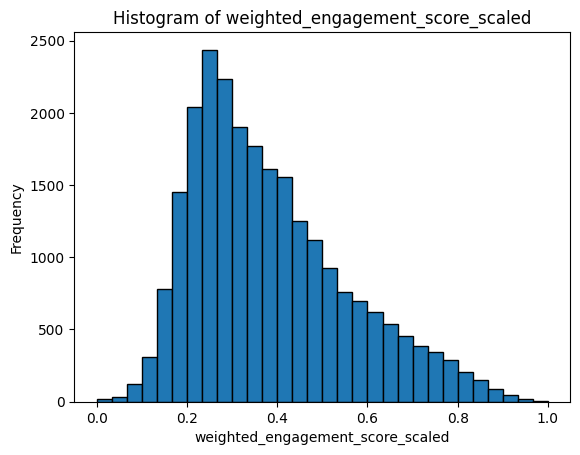

In [ ]:
video['weighted_engagement_score_scaled'].plot(kind='hist', bins=30, edgecolor='black')
plt.title('Histogram of weighted_engagement_score_scaled')
plt.xlabel('weighted_engagement_score_scaled')
plt.ylabel('Frequency')
plt.show()

## Scatter Plot: KPI vs. Engagement Score
This cell creates a scatter plot to visualize the relationship between the scaled weighted engagement score and the KPI for each video.

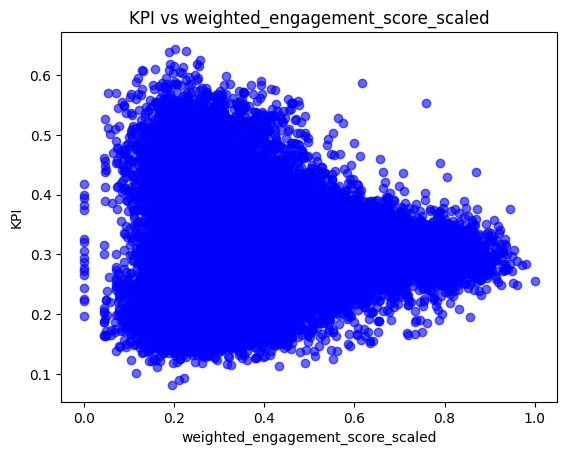

In [ ]:
# Scatter plot of KPI vs Engagement Score
plt.scatter(video['weighted_engagement_score_scaled'], video['KPI'], alpha=0.6, color='blue')

# Add axis labels and title
plt.ylabel("KPI")
plt.xlabel("weighted_engagement_score_scaled")
plt.title("KPI vs weighted_engagement_score_scaled")

# Show the plot
plt.show()

## Scatter Plot: View Count vs. Engagement Score
This cell creates a scatter plot to visualize the relationship between the scaled weighted engagement score and the view count for each video.

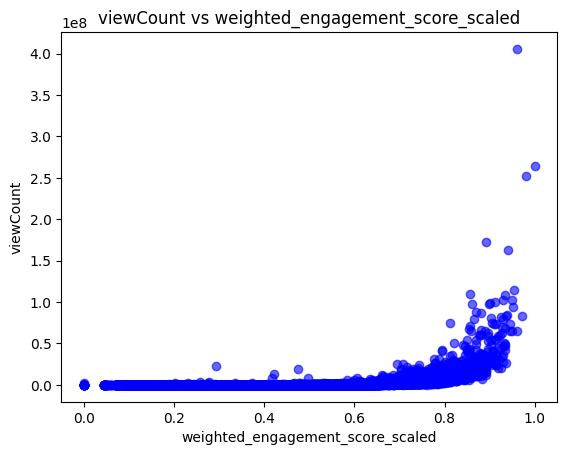

In [ ]:
# Scatter plot of KPI vs weighted_engagement_score_scaled
plt.scatter(video['weighted_engagement_score_scaled'], video['viewCount'], alpha=0.6, color='blue')

# Add axis labels and title
plt.ylabel("viewCount")
plt.xlabel("weighted_engagement_score_scaled")
plt.title("viewCount vs weighted_engagement_score_scaled")

# Show the plot
plt.show()

## Count Videos with High Engagement Score
This cell counts the number of videos with a scaled weighted engagement score greater than 0.8.

In [ ]:
video.loc[video['weighted_engagement_score_scaled']>0.8].shape

(505, 26)

## Group High Engagement Videos by Topic
This cell groups videos with a scaled weighted engagement score above 0.8 by their topic label and counts the number of unique videos per topic.

In [ ]:
video.loc[video['weighted_engagement_score_scaled']>0.8].groupby("topic_label")[['videoId']].nunique()

,videoId
topic_label,
body,35
hair,135
makeup,257
perfume,35
skin,42


## Sort and Display Top Videos by Engagement
This cell sorts videos by their scaled weighted engagement score in descending order and displays the top 10 videos with key metrics.

In [ ]:
video.sort_values(by = "weighted_engagement_score_scaled", ascending=False, inplace=True)
video[['translated', 'KPI', "weighted_engagement_score_scaled",'viewCount', 'likeCount', 'commentCount', 'comment_count']].head(10)

,translated,KPI,weighted_engagement_score_scaled,viewCount,likeCount,commentCount,comment_count
14062,sydney sweeney perfecting shot,0.255842,1.000000,264368764.000000,7162433.000000,4063.000000,1773
6692,freaky friday brow made gem,0.284013,0.981042,252195721.000000,5409360.000000,13039.000000,2015
309,favortie hairstyle shortvideo short short,0.282932,0.971054,83582866.000000,4065512.000000,70980.000000,33137
11152,korean secret glowing skin mask | beauty secrets| look beautiful short,0.249368,0.960695,405748145.000000,4102127.000000,4813.000000,636
13940,pakistan cute girl makeup video| good makeup video | vairl reel video short cute,0.289186,0.960018,64574323.000000,3412828.000000,9756.000000,1781
13001,every girl gorgeous make,0.308141,0.954028,114243754.000000,3403059.000000,10273.000000,2000
1100,happened,0.252080,0.951557,94427588.000000,3201411.000000,24661.000000,5094
22600,made feel blue,0.297605,0.950144,64583962.000000,2991714.000000,10969.000000,5723
15382,think used much bronzing drop,0.272179,0.949484,102571469.000000,3129194.000000,34120.000000,809
16231,men think no makeup makeup,0.376624,0.945674,73583132.000000,2828588.000000,51595.000000,35243


## Prepare Final Video Output DataFrame
This cell selects relevant columns for the final video output DataFrame, preparing it for export.

In [ ]:
video_output = video[['videoId', 'publishedAt', 'channelId', 'title', 'description', 'tags',
       'defaultLanguage', 'defaultAudioLanguage', 'contentDuration',
       'viewCount', 'likeCount', 'commentCount', 'topicCategories',
       'cleanedText', 'is_english', 'translated', 'extracted_topicCategories',
       'extracted_topicCategories_str', 'KPI', 'comment_count', 'weighted_engagement_score_scaled']]


## Rename Output Columns
This cell renames columns in the final output DataFrame for clarity, such as changing 'KPI' to 'average_kpi' and the engagement score column to 'video_engagement_score'.

In [ ]:
video_output.rename(columns={
    "KPI": "average_kpi",
    "weighted_engagement_score_scaled": "video_engagement_score"
}, inplace=True)


## Display Final Output Shape
This cell displays the shape of the final video output DataFrame to confirm the number of records and columns before export.

In [ ]:
video_output.shape

(24138, 24)

## Export Final Video Output to CSV
This cell exports the final video output DataFrame to a CSV file for downstream analysis or reporting.

In [ ]:
video_output.to_csv("dataset/video_with_engagement_score.csv", index = False)